# Download [zip_code_market_tracker.tsv000](https://www.kaggle.com/datasets/thuynyle/redfin-housing-market-data?select=zip_code_market_tracker.tsv000)

In [22]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

## Loading and Extracting Relevant Data (Charlotte Metro Area)

In [23]:
!awk -F'\t' 'BEGIN {OFS="\t"} {NF=58; print}' zip_code_market_tracker.tsv000 > cleaned_data.tsv

In [24]:
charlotte_df = pl.scan_csv("cleaned_data.tsv", separator="\t").filter(
    (pl.col("parent_metro_region")  == 'Charlotte, NC') & 
    (pl.col("property_type") == 'All Residential'))

In [25]:
# Select final features
features_to_keep = [
    # Identifiers
    'period_begin', 'period_end', 'region', 'state_code',
    
    # Target
    'median_sale_price',
    
    # Core features (Tier 1)
    'median_list_price', 'median_ppsf',
    'homes_sold', 'inventory', 'new_listings', 'months_of_supply',
    'median_dom', 'pending_sales',
    'avg_sale_to_list', 'sold_above_list',
    'price_drops', 'off_market_in_two_weeks',
    
    # Pre-calculated trends (Tier 1)
    'median_sale_price_mom', 'median_sale_price_yoy',
    'months_of_supply_mom', 'months_of_supply_yoy',
    
    # Additional momentum (Tier 2)
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy',
    'price_drops_mom', 'price_drops_yoy',
    'pending_sales_mom', 'pending_sales_yoy',
    'new_listings_mom', 'new_listings_yoy',
]

# Filter and select
charlotte_clean = charlotte_df.select(features_to_keep)
# clean region zip code format
charlotte_clean = charlotte_clean.with_columns(
    pl.col("region").str.replace_all("Zip Code: ", "")
)

In [26]:
# Collect and save initial data
charlotte_clean.collect().write_csv("charlotte_data.csv")

In [27]:
!rm cleaned_data.tsv

In [28]:
# Load data with pandas for EDA
df = pd.read_csv("charlotte_data.csv")
df.head(10)
df.shape

(11765, 33)

## Exploratory Data Analysis

In [29]:
# Add quarter labels and dataset summary
quarter_labels = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}

# Ensure required temporal columns exist (derive if missing)
if 'quarter' not in df.columns or 'year' not in df.columns:
    dt = pd.to_datetime(df['period_begin'])
    if 'quarter' not in df.columns:
        df['quarter'] = dt.dt.quarter
    if 'year' not in df.columns:
        df['year'] = dt.dt.year

# Map quarter label and create year-quarter composite
df['quarter_label'] = df['quarter'].map(quarter_labels)
df['year_quarter'] = df['year'].astype(str) + '-' + df['quarter_label']

# Dataset summary
print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
if 'period_end' in df.columns:
    print(f"Date range: {df['period_begin'].min()} to {df['period_end'].max()}")
else:
    print(f"Date range (begin only): {df['period_begin'].min()} to {df['period_begin'].max()}")
print(f"Years: {df['year'].min()} to {df['year'].max()}")
print(f"Zip codes: {df['region'].nunique()}")

# Year distribution
print("\nYear distribution (using period_end/year):")
print(df['year'].value_counts().sort_index())

# Quarter distribution
print("\nQuarter distribution:")
print(df['quarter'].value_counts().sort_index())

Dataset: 11,765 rows × 37 columns
Date range: 2013-02-01 to 2021-12-31
Years: 2013 to 2021
Zip codes: 131

Year distribution (using period_end/year):
year
2013    1191
2014    1320
2015    1328
2016    1348
2017    1347
2018    1345
2019    1375
2020    1356
2021    1155
Name: count, dtype: int64

Quarter distribution:
quarter
1    2894
2    3053
3    3029
4    2789
Name: count, dtype: int64


extra stuff

 ========== TIME COVERAGE ANALYSIS ==========
time_coverage = df.group_by('region').agg([
    pl.len().alias('quarters'),
    pl.col('period_begin').min().alias('first_quarter'),
    pl.col('period_begin').max().alias('last_quarter'),
    pl.col('median_sale_price').null_count().alias('missing_prices')
]).sort('quarters', descending=True)

print(f"Zips with FULL coverage (30+ quarters): {len(time_coverage.filter(pl.col('quarters') >= 30))} - suitable for LSTM")
print(f"Zips with PARTIAL coverage (15-29 quarters): {len(time_coverage.filter((pl.col('quarters') >= 15) & (pl.col('quarters') < 30)))}")
print(f"Zips with LIMITED coverage (<15 quarters): {len(time_coverage.filter(pl.col('quarters') < 15))}")

complete_zips = time_coverage.filter(pl.col('quarters') >= 30)['region'].to_list()

### Missing Data

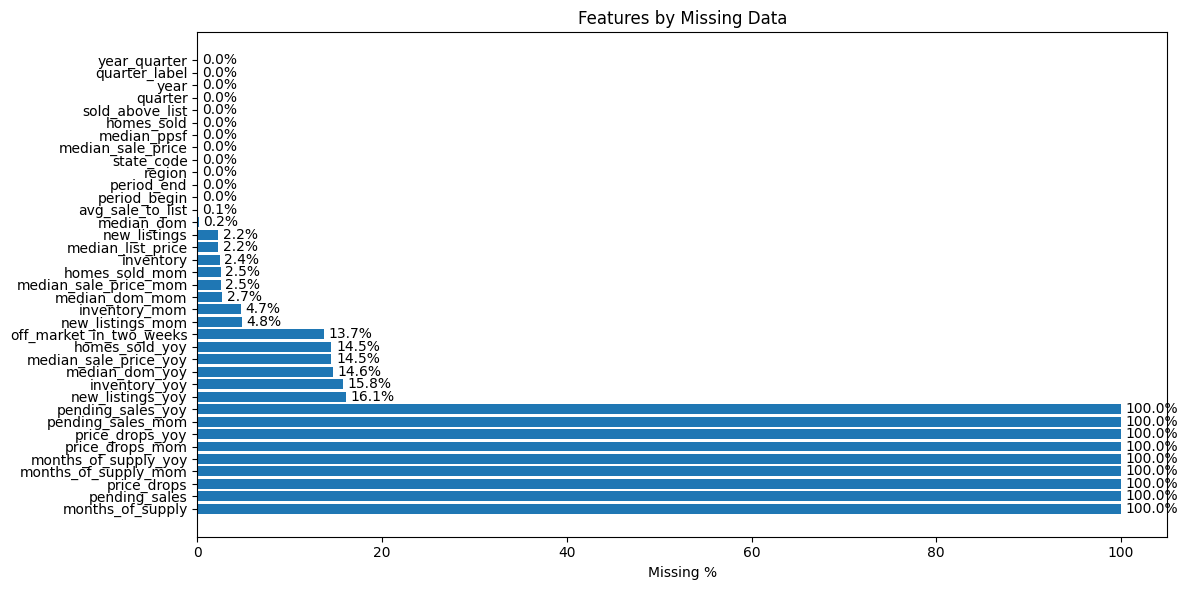


Total missing values: 0


In [30]:
# Calculate missing data percentages
missing_pct = [(col, df[col].isna().sum() / len(df) * 100) for col in df.columns]
missing_pct = sorted(missing_pct, key=lambda x: x[1], reverse=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh([x[0] for x in missing_pct], [x[1] for x in missing_pct])
for i, (col, pct) in enumerate(missing_pct):
    ax.text(pct + 0.5, i, f"{pct:.1f}%", va='center')
ax.set_xlabel('Missing %')
ax.set_title('Features by Missing Data')
plt.tight_layout()
plt.show()

# ========== STEP 1: DROP EMPTY COLUMNS ==========
empty_columns = [
    'months_of_supply', 'pending_sales', 'price_drops',
    'months_of_supply_mom', 'months_of_supply_yoy',
    'price_drops_mom', 'price_drops_yoy',
    'pending_sales_mom', 'pending_sales_yoy',
]
df = df.drop(columns=empty_columns)

# ========== STEP 2: FILL YoY WITH 0 ==========
yoy_columns = [
    'median_sale_price_yoy', 'homes_sold_yoy', 'inventory_yoy',
    'median_dom_yoy', 'new_listings_yoy',
]
for col in yoy_columns:
    df[col] = df[col].fillna(0)

# ========== STEP 3: FILL off_market_in_two_weeks ==========
median_omtw = df['off_market_in_two_weeks'].median()
df['off_market_in_two_weeks'] = df['off_market_in_two_weeks'].fillna(median_omtw)

# ========== STEP 4: FORWARD FILL + MEDIAN FOR SMALL GAPS ==========
small_missing = [
    'new_listings', 'median_list_price', 'inventory',
    'homes_sold_mom', 'median_sale_price_mom', 'median_dom_mom',
    'inventory_mom', 'new_listings_mom',
]

df = df.sort_values(['region', 'period_begin'])

for col in small_missing:
    # OLD (deprecated): df[col] = df.groupby('region')[col].fillna(method='ffill')
    # NEW (correct): use ffill/bfill
    df[col] = df.groupby('region')[col].ffill()
    df[col] = df.groupby('region')[col].bfill()
    df[col] = df[col].fillna(df[col].median())

# ========== STEP 5: FILL FINAL REMAINING ==========
df['median_dom'] = df['median_dom'].fillna(df['median_dom'].median())
df['avg_sale_to_list'] = df['avg_sale_to_list'].fillna(df['avg_sale_to_list'].median())

# ========== STEP 6: VERIFY ==========
total_missing = df.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

### Target Variable Analysis - `median_sale_price`

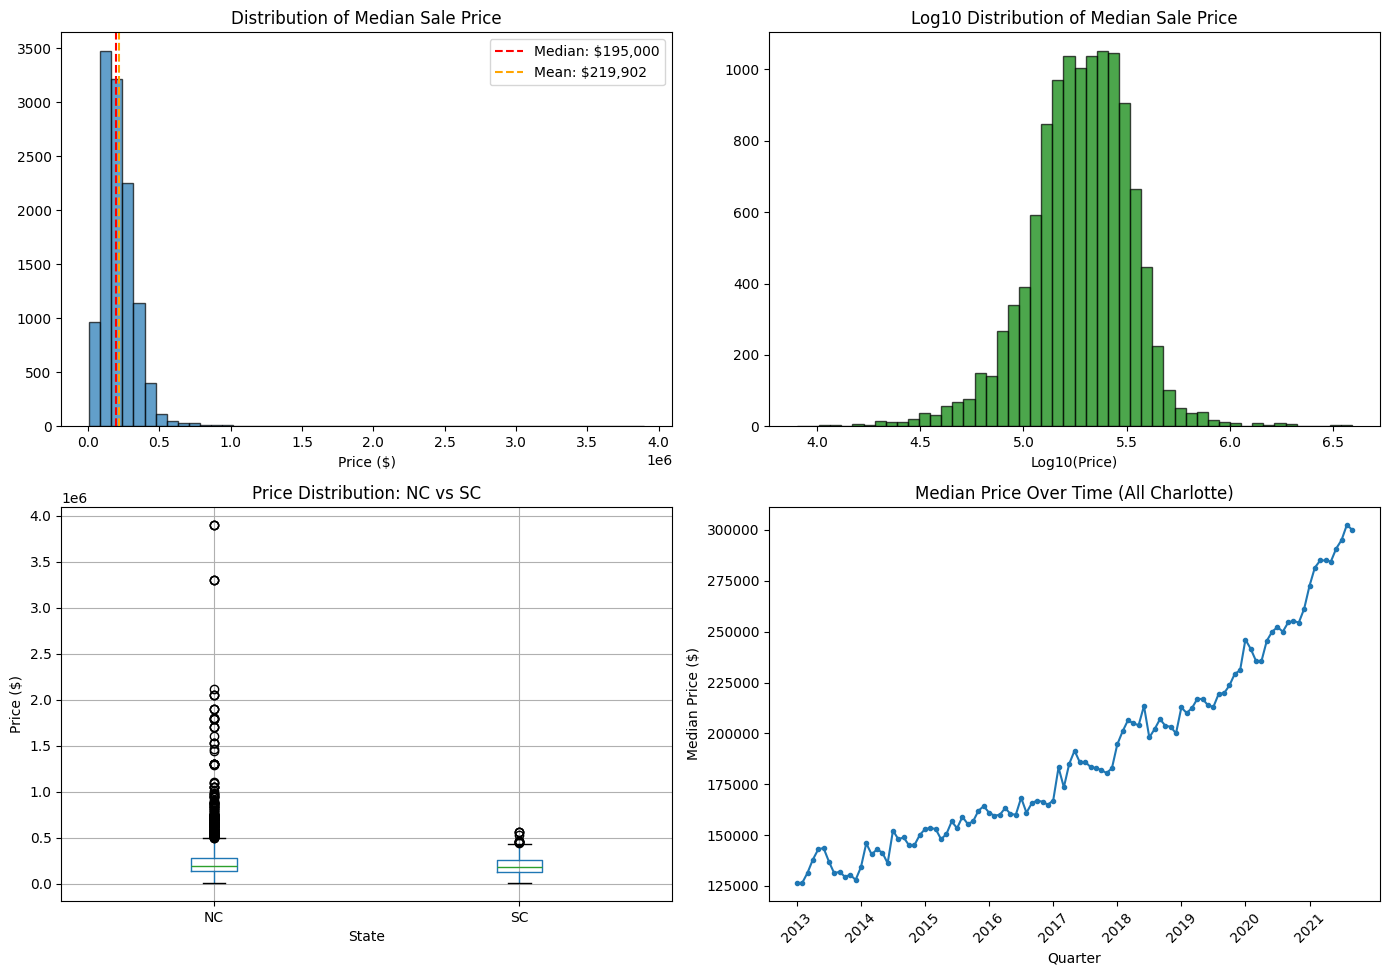


Target Variable Summary:
count    1.176500e+04
mean     2.199024e+05
std      1.551210e+05
min      8.000000e+03
25%      1.350000e+05
50%      1.950000e+05
75%      2.750500e+05
max      3.900000e+06
Name: median_sale_price, dtype: float64


In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1.1 Distribution
axes[0,0].hist(df['median_sale_price'], bins=50, edgecolor='black', alpha=0.7)
axes[0,0].axvline(df['median_sale_price'].median(), color='red', linestyle='--', 
                   label=f"Median: ${df['median_sale_price'].median():,.0f}")
axes[0,0].axvline(df['median_sale_price'].mean(), color='orange', linestyle='--',
                   label=f"Mean: ${df['median_sale_price'].mean():,.0f}")
axes[0,0].set_title('Distribution of Median Sale Price')
axes[0,0].set_xlabel('Price ($)')
axes[0,0].legend()

# 1.2 Log distribution
axes[0,1].hist(np.log10(df['median_sale_price']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0,1].set_title('Log10 Distribution of Median Sale Price')
axes[0,1].set_xlabel('Log10(Price)')

# 1.3 Box plot by state
df.boxplot(column='median_sale_price', by='state_code', ax=axes[1,0])
axes[1,0].set_title('Price Distribution: NC vs SC')
axes[1,0].set_ylabel('Price ($)')
axes[1,0].set_xlabel('State')
plt.suptitle('')

# 1.4 Price over time
time_trend = df.groupby('period_begin')['median_sale_price'].median().reset_index()
axes[1,1].plot(range(len(time_trend)), time_trend['median_sale_price'], marker='o', markersize=3)
axes[1,1].set_title('Median Price Over Time (All Charlotte)')
axes[1,1].set_xlabel('Quarter')
axes[1,1].set_ylabel('Median Price ($)')
# Add year labels
year_positions = [i for i, date in enumerate(time_trend['period_begin']) if date.endswith('02-01')]
year_labels = [date[:4] for date in time_trend['period_begin'] if date.endswith('02-01')]
axes[1,1].set_xticks(year_positions)
axes[1,1].set_xticklabels(year_labels, rotation=45)

plt.tight_layout()
plt.show()

# Summary stats
print("\nTarget Variable Summary:")
print(df['median_sale_price'].describe())

### Temporal Analysis

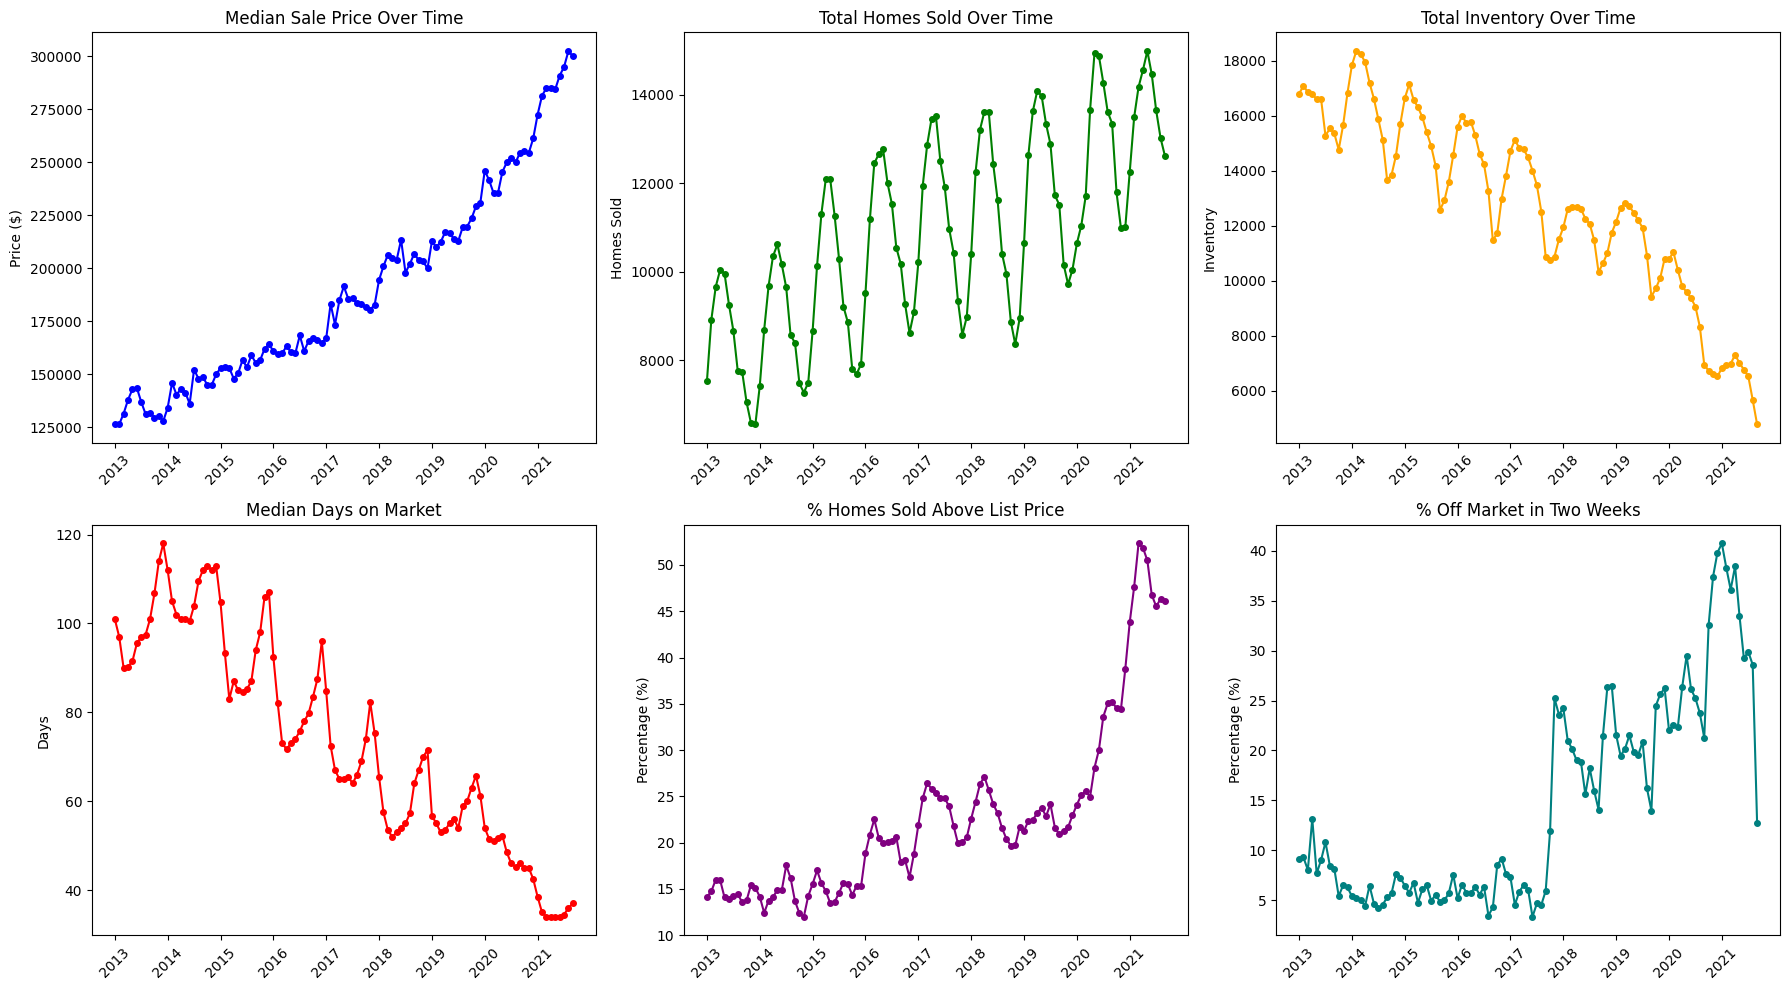

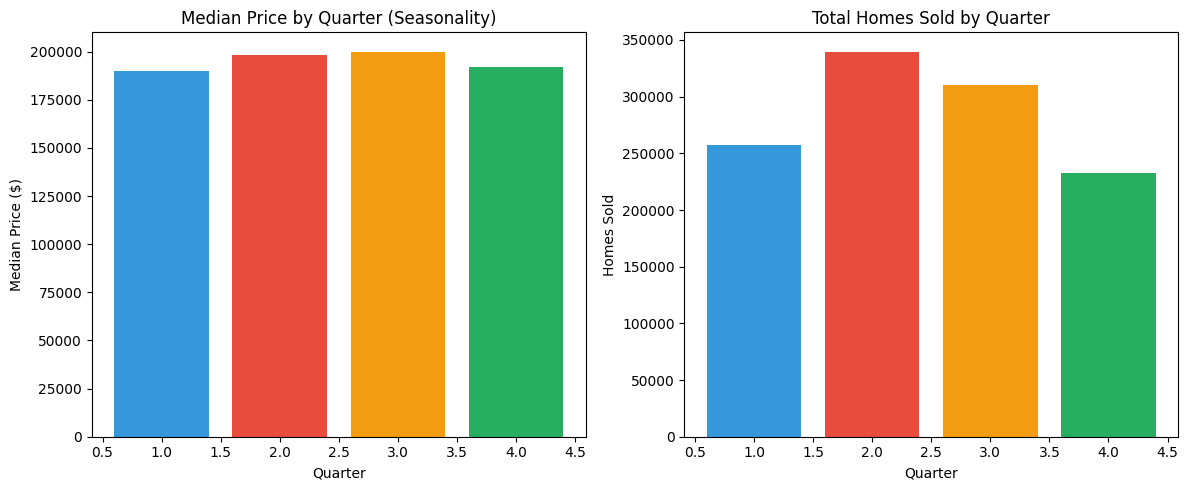


📊 SEASONALITY INSIGHTS:
  Highest price quarter: 3 ($200,000)
  Lowest price quarter:  1 ($189,900)
  Highest volume quarter: 2 (339,754 homes)
  Lowest volume quarter:  4 (232,650 homes)


In [32]:
# Aggregate by quarter
quarterly = df.groupby('period_begin').agg({
    'median_sale_price': 'median',
    'homes_sold': 'sum',
    'inventory': 'sum',
    'median_dom': 'median',
    'sold_above_list': 'mean',
    'off_market_in_two_weeks': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 2.1 Price trend
axes[0,0].plot(range(len(quarterly)), quarterly['median_sale_price'], marker='o', markersize=4, color='blue')
axes[0,0].set_title('Median Sale Price Over Time')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].set_xticks(year_positions)
axes[0,0].set_xticklabels(year_labels, rotation=45)

# 2.2 Volume trend
axes[0,1].plot(range(len(quarterly)), quarterly['homes_sold'], marker='o', markersize=4, color='green')
axes[0,1].set_title('Total Homes Sold Over Time')
axes[0,1].set_ylabel('Homes Sold')
axes[0,1].set_xticks(year_positions)
axes[0,1].set_xticklabels(year_labels, rotation=45)

# 2.3 Inventory trend
axes[0,2].plot(range(len(quarterly)), quarterly['inventory'], marker='o', markersize=4, color='orange')
axes[0,2].set_title('Total Inventory Over Time')
axes[0,2].set_ylabel('Inventory')
axes[0,2].set_xticks(year_positions)
axes[0,2].set_xticklabels(year_labels, rotation=45)

# 2.4 Days on market
axes[1,0].plot(range(len(quarterly)), quarterly['median_dom'], marker='o', markersize=4, color='red')
axes[1,0].set_title('Median Days on Market')
axes[1,0].set_ylabel('Days')
axes[1,0].set_xticks(year_positions)
axes[1,0].set_xticklabels(year_labels, rotation=45)

# 2.5 % Sold above list
axes[1,1].plot(range(len(quarterly)), quarterly['sold_above_list']*100, marker='o', markersize=4, color='purple')
axes[1,1].set_title('% Homes Sold Above List Price')
axes[1,1].set_ylabel('Percentage (%)')
axes[1,1].set_xticks(year_positions)
axes[1,1].set_xticklabels(year_labels, rotation=45)

# 2.6 Quick sales
axes[1,2].plot(range(len(quarterly)), quarterly['off_market_in_two_weeks']*100, marker='o', markersize=4, color='teal')
axes[1,2].set_title('% Off Market in Two Weeks')
axes[1,2].set_ylabel('Percentage (%)')
axes[1,2].set_xticks(year_positions)
axes[1,2].set_xticklabels(year_labels, rotation=45)

plt.tight_layout()
plt.show()

# SEASONALITY
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

seasonal_price = df.groupby('quarter')['median_sale_price'].median()
seasonal_volume = df.groupby('quarter')['homes_sold'].sum()

axes[0].bar(seasonal_price.index, seasonal_price.values, color=['#3498db', '#e74c3c', '#f39c12', '#27ae60'])
axes[0].set_title('Median Price by Quarter (Seasonality)')
axes[0].set_ylabel('Median Price ($)')
axes[0].set_xlabel('Quarter')

axes[1].bar(seasonal_volume.index, seasonal_volume.values, color=['#3498db', '#e74c3c', '#f39c12', '#27ae60'])
axes[1].set_title('Total Homes Sold by Quarter')
axes[1].set_ylabel('Homes Sold')
axes[1].set_xlabel('Quarter')

plt.tight_layout()
plt.show()

print(f"\n📊 SEASONALITY INSIGHTS:")
print(f"  Highest price quarter: {seasonal_price.idxmax()} (${seasonal_price.max():,.0f})")
print(f"  Lowest price quarter:  {seasonal_price.idxmin()} (${seasonal_price.min():,.0f})")
print(f"  Highest volume quarter: {seasonal_volume.idxmax()} ({seasonal_volume.max():,} homes)")
print(f"  Lowest volume quarter:  {seasonal_volume.idxmin()} ({seasonal_volume.min():,} homes)")


### Geographic Analysis

Recent data (2020-2021): 2511 records
Years in recent data: [2020 2021]


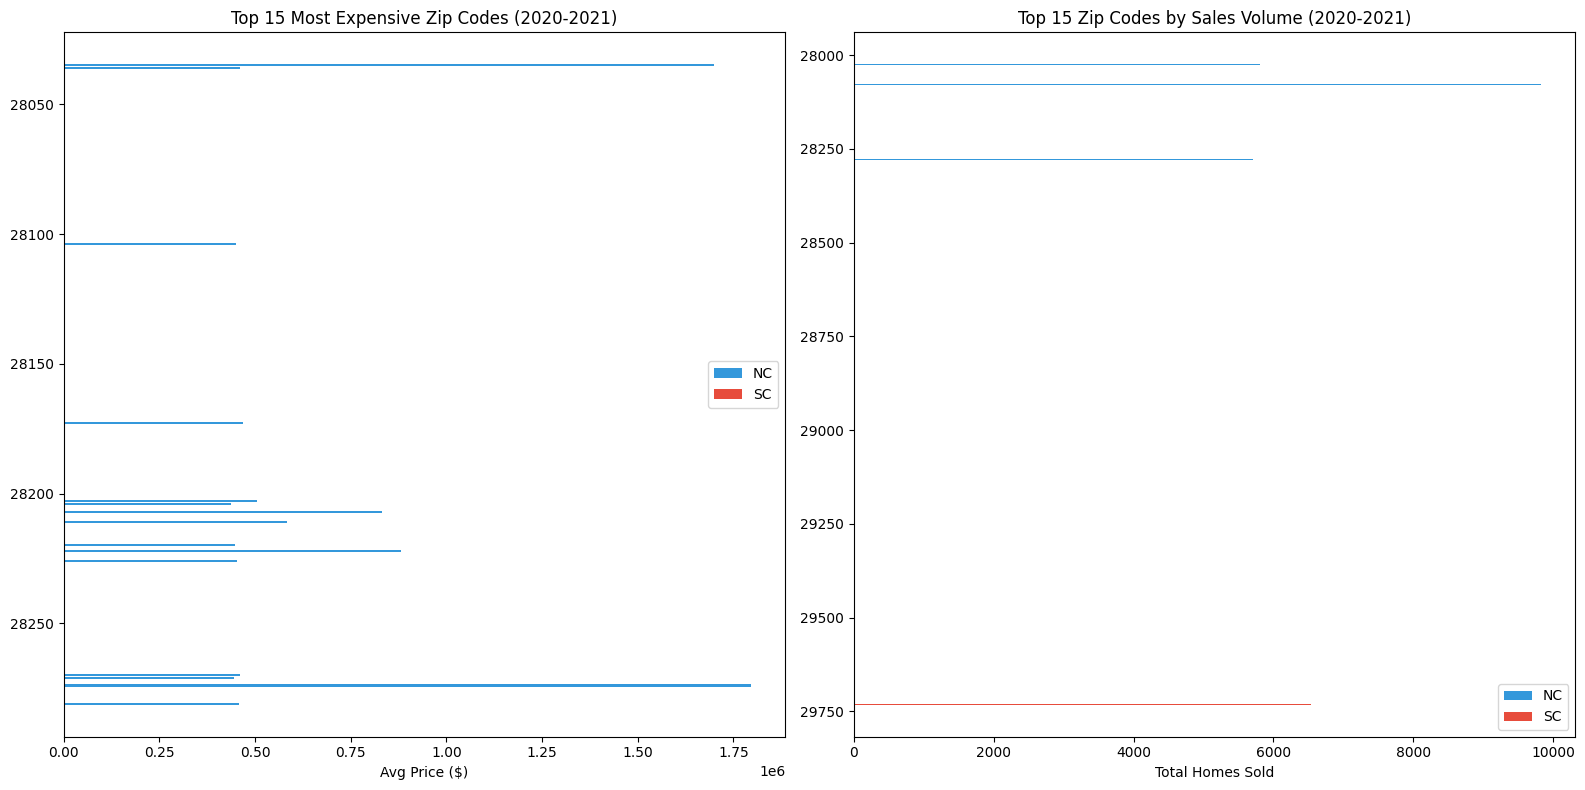


📍 NC vs SC COMPARISON (2020-2021):
            avg_price  total_sold  avg_dom  num_zips
state_code                                          
NC          299032.82      239518    51.75       103
SC          247314.84       45706    53.31        22

🏆 TOP 5 MOST EXPENSIVE ZIP CODES:
         avg_price  total_sold  avg_dom state
region                                       
28274   1795625.00           9    30.75    NC
28035   1700000.00           3    71.50    NC
28222    881277.50          15   138.00    NC
28207    830863.64        1518    56.27    NC
28211    584000.00        3808    52.91    NC

🔥 TOP 5 HOTTEST MARKETS (fastest sales):
        avg_price  total_sold  avg_dom state
region                                      
28221   153600.00           5    22.80    NC
28106   217666.67           9    23.33    NC
28070   345551.36          15    24.91    NC
29031   161200.00           5    27.60    SC
28213   238437.16        3616    28.20    NC


In [33]:
# Recent data (2020-2021)
recent = df[df['year'] >= 2020]

print(f"Recent data (2020-2021): {len(recent)} records")
print(f"Years in recent data: {recent['year'].unique()}")

zip_stats = recent.groupby('region').agg({
    'median_sale_price': 'mean',
    'homes_sold': 'sum',
    'median_dom': 'mean',
    'sold_above_list': 'mean',
    'state_code': 'first'
}).round(2)
zip_stats.columns = ['avg_price', 'total_sold', 'avg_dom', 'pct_above_list', 'state']
zip_stats = zip_stats.sort_values('avg_price', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 most expensive
top_15 = zip_stats.head(15)
colors = ['#3498db' if s == 'NC' else '#e74c3c' for s in top_15['state']]
axes[0].barh(top_15.index, top_15['avg_price'], color=colors)
axes[0].set_title('Top 15 Most Expensive Zip Codes (2020-2021)')
axes[0].set_xlabel('Avg Price ($)')
axes[0].invert_yaxis()
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='NC'), Patch(facecolor='#e74c3c', label='SC')]
axes[0].legend(handles=legend_elements)

# Top 15 by volume
by_volume = zip_stats.sort_values('total_sold', ascending=False).head(15)
colors = ['#3498db' if s == 'NC' else '#e74c3c' for s in by_volume['state']]
axes[1].barh(by_volume.index, by_volume['total_sold'], color=colors)
axes[1].set_title('Top 15 Zip Codes by Sales Volume (2020-2021)')
axes[1].set_xlabel('Total Homes Sold')
axes[1].invert_yaxis()
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# NC vs SC comparison
print("\n📍 NC vs SC COMPARISON (2020-2021):")
state_comp = recent.groupby('state_code').agg({
    'median_sale_price': 'mean',
    'homes_sold': 'sum',
    'median_dom': 'mean',
    'region': 'nunique'
}).round(2)
state_comp.columns = ['avg_price', 'total_sold', 'avg_dom', 'num_zips']
print(state_comp)

print("\n🏆 TOP 5 MOST EXPENSIVE ZIP CODES:")
print(zip_stats.head(5)[['avg_price', 'total_sold', 'avg_dom', 'state']])

print("\n🔥 TOP 5 HOTTEST MARKETS (fastest sales):")
hottest = zip_stats.sort_values('avg_dom').head(5)
print(hottest[['avg_price', 'total_sold', 'avg_dom', 'state']])

### Feature Correlations

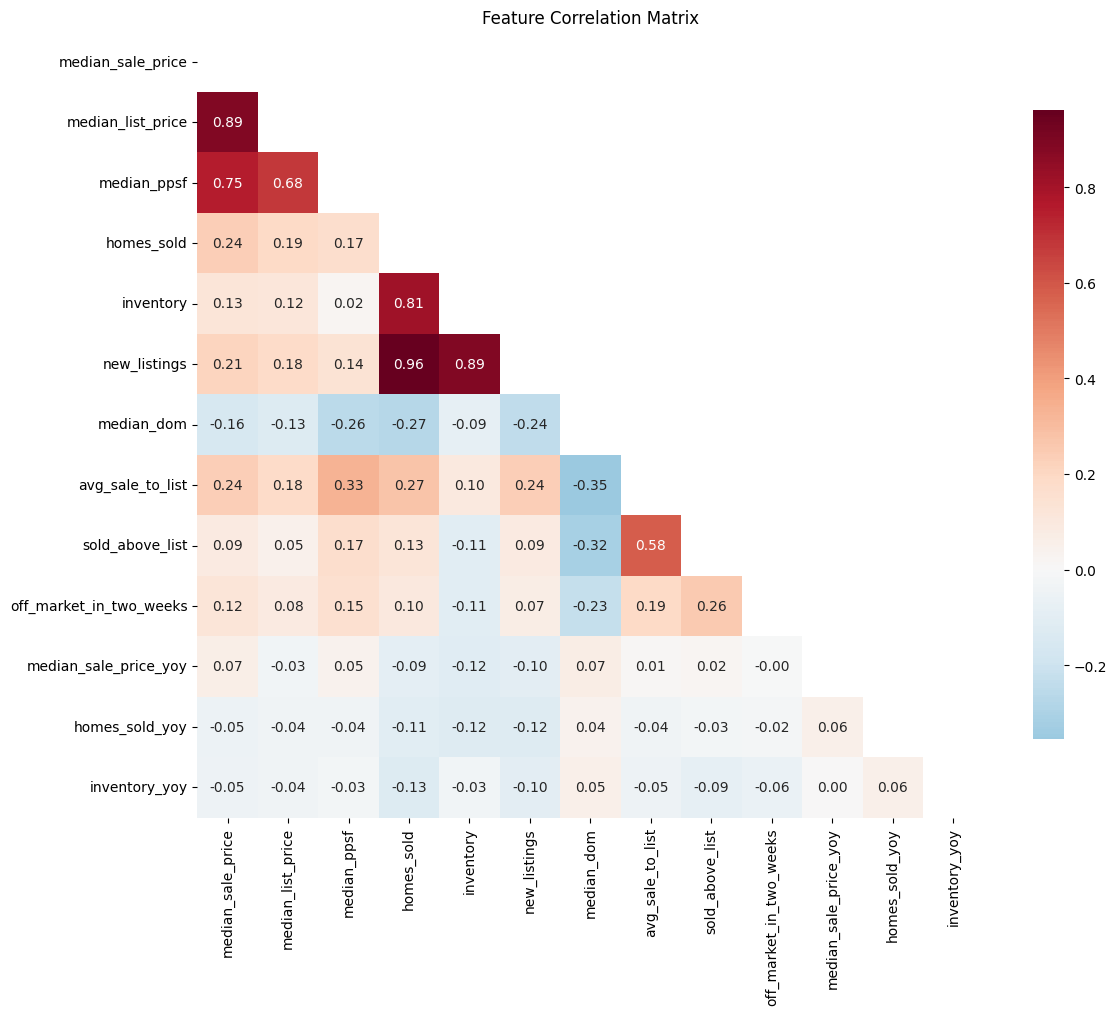

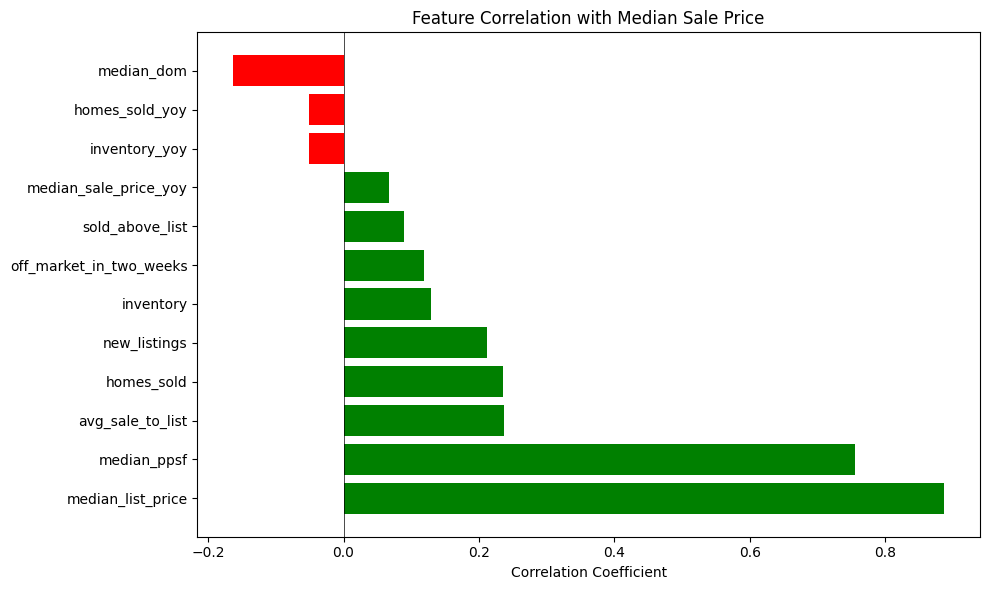


🔥 TOP POSITIVE CORRELATIONS with price:
median_list_price    0.887376
median_ppsf          0.754971
avg_sale_to_list     0.236738
homes_sold           0.235990
new_listings         0.211170
Name: median_sale_price, dtype: float64

❄️ TOP NEGATIVE CORRELATIONS with price:
sold_above_list          0.088687
median_sale_price_yoy    0.066541
inventory_yoy           -0.050463
homes_sold_yoy          -0.051402
median_dom              -0.163374
Name: median_sale_price, dtype: float64


In [34]:
# Select numerical features
num_features = [
    'median_sale_price', 'median_list_price', 'median_ppsf',
    'homes_sold', 'inventory', 'new_listings',
    'median_dom', 'avg_sale_to_list', 'sold_above_list',
    'off_market_in_two_weeks',
    'median_sale_price_yoy', 'homes_sold_yoy', 'inventory_yoy'
]

corr_matrix = df[num_features].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Correlation with target
target_corr = corr_matrix['median_sale_price'].drop('median_sale_price').sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
ax.barh(target_corr.index, target_corr.values, color=colors)
ax.set_title('Feature Correlation with Median Sale Price')
ax.set_xlabel('Correlation Coefficient')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n🔥 TOP POSITIVE CORRELATIONS with price:")
print(target_corr.head(5))
print("\n❄️ TOP NEGATIVE CORRELATIONS with price:")
print(target_corr.tail(5))


### Market Health & Phase Classification


📊 MARKET PHASE DISTRIBUTION:
market_phase
COLD      4774
HOT       3974
STABLE    3017
Name: count, dtype: int64

Percentages:
market_phase
COLD      40.6
HOT       33.8
STABLE    25.6
Name: count, dtype: float64


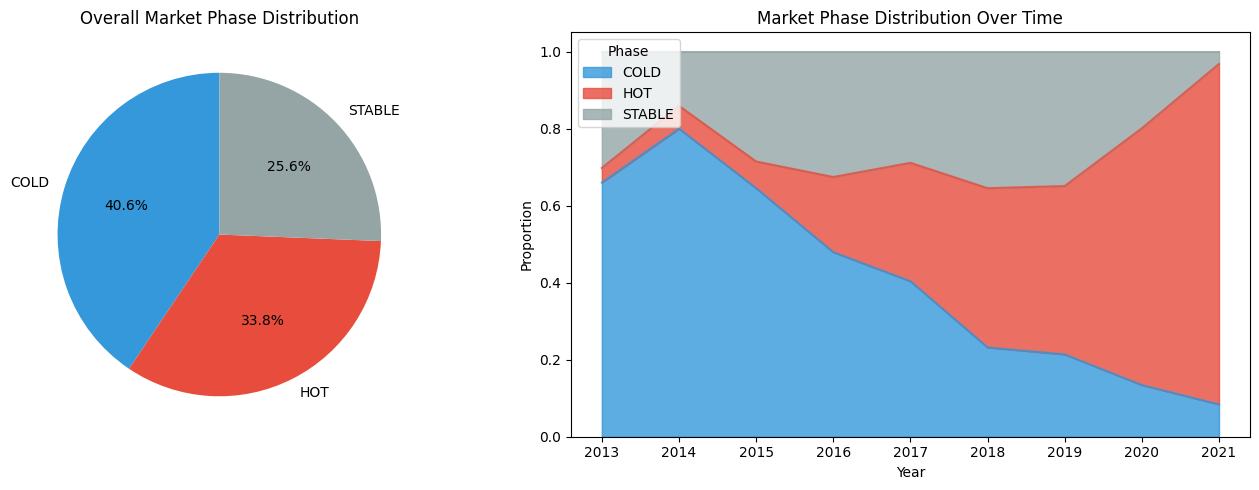


📅 MARKET PHASE BY YEAR:
market_phase  COLD   HOT  STABLE
year                            
2013          66.0   3.8    30.2
2014          80.0   5.9    14.1
2015          64.5   6.9    28.5
2016          47.9  19.5    32.6
2017          40.4  30.7    28.9
2018          23.2  41.3    35.5
2019          21.4  43.7    34.9
2020          13.4  66.7    19.9
2021           8.4  88.4     3.2


In [35]:
# Create market phase labels
def classify_market(row):
    hot_signals = 0
    cold_signals = 0
    
    # HOT indicators
    if row['sold_above_list'] > 0.25: hot_signals += 1
    if row['median_dom'] < 50: hot_signals += 1
    if row['median_sale_price_yoy'] > 0.05: hot_signals += 1
    if row['off_market_in_two_weeks'] > 0.35: hot_signals += 1
    
    # COLD indicators
    if row['sold_above_list'] < 0.10: cold_signals += 1
    if row['median_dom'] > 90: cold_signals += 1
    if row['median_sale_price_yoy'] < 0: cold_signals += 1
    if row['off_market_in_two_weeks'] < 0.15: cold_signals += 1
    
    if hot_signals >= 2: return 'HOT'
    elif cold_signals >= 2: return 'COLD'
    else: return 'STABLE'

df['market_phase'] = df.apply(classify_market, axis=1)

print("\n📊 MARKET PHASE DISTRIBUTION:")
phase_counts = df['market_phase'].value_counts()
print(phase_counts)
print(f"\nPercentages:")
print((phase_counts / len(df) * 100).round(1))

# Visualize market phases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors_pie = {'HOT': '#e74c3c', 'STABLE': '#95a5a6', 'COLD': '#3498db'}
axes[0].pie(phase_counts.values, labels=phase_counts.index, autopct='%1.1f%%',
            colors=[colors_pie[p] for p in phase_counts.index], startangle=90)
axes[0].set_title('Overall Market Phase Distribution')

# Stacked area over time
phase_time = df.groupby(['year', 'market_phase']).size().unstack(fill_value=0)
phase_time_pct = phase_time.div(phase_time.sum(axis=1), axis=0)
phase_time_pct.plot(kind='area', stacked=True, ax=axes[1],
                     color=[colors_pie.get(c, 'gray') for c in phase_time_pct.columns], alpha=0.8)
axes[1].set_title('Market Phase Distribution Over Time')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Year')
axes[1].legend(title='Phase', loc='upper left')

plt.tight_layout()
plt.show()

# Market phase by year
print("\n📅 MARKET PHASE BY YEAR:")
phase_by_year = df.groupby(['year', 'market_phase']).size().unstack(fill_value=0)
phase_by_year_pct = phase_by_year.div(phase_by_year.sum(axis=1), axis=0) * 100
print(phase_by_year_pct.round(1))


### Year-over-Year Growth Analysis

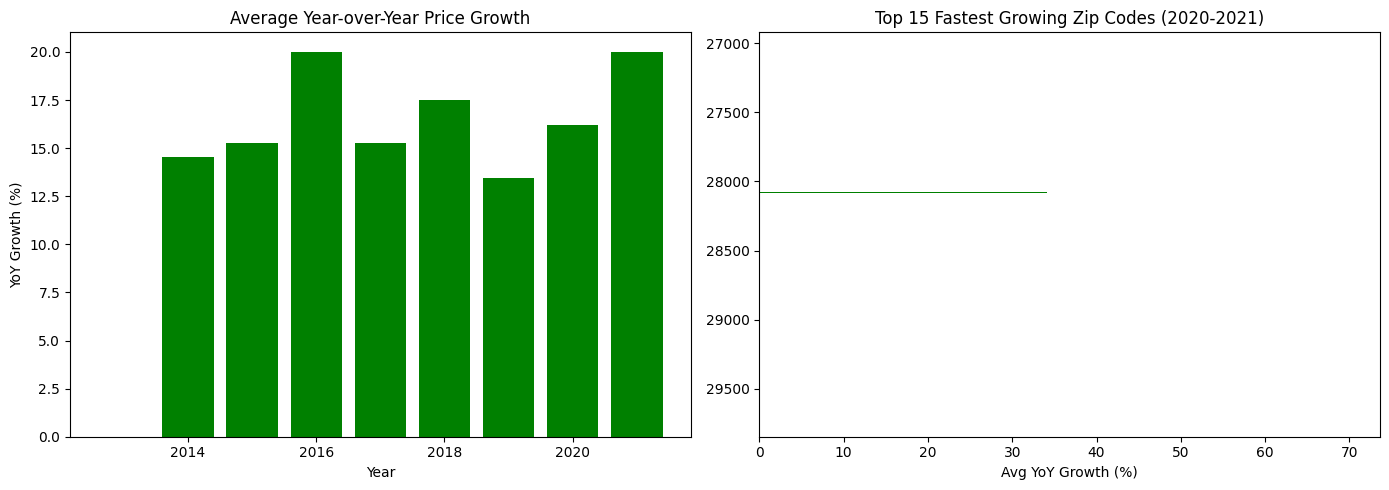


📈 AVERAGE YoY PRICE GROWTH BY YEAR:
  2013: +0.0%
  2014: +14.5%
  2015: +15.3%
  2016: +20.0%
  2017: +15.3%
  2018: +17.5%
  2019: +13.4%
  2020: +16.2%
  2021: +20.0%

🚀 TOP 5 FASTEST GROWING ZIP CODES (2020-2021):
region
28091    70.12
28254    68.92
28119    60.13
28660    56.37
28077    49.61
Name: median_sale_price_yoy, dtype: float64


In [36]:
# YoY growth by year
yoy_by_year = df.groupby('year')['median_sale_price_yoy'].mean() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of YoY growth
colors = ['green' if x > 0 else 'red' for x in yoy_by_year.values]
axes[0].bar(yoy_by_year.index, yoy_by_year.values, color=colors)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_title('Average Year-over-Year Price Growth')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('YoY Growth (%)')

# Top growing zip codes (2020-2021)
recent_growth = recent.groupby('region')['median_sale_price_yoy'].mean().sort_values(ascending=False) * 100
top_growth = recent_growth.head(15)
axes[1].barh(top_growth.index, top_growth.values, color='green')
axes[1].set_title('Top 15 Fastest Growing Zip Codes (2020-2021)')
axes[1].set_xlabel('Avg YoY Growth (%)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n📈 AVERAGE YoY PRICE GROWTH BY YEAR:")
for year, growth in yoy_by_year.items():
    print(f"  {year}: {growth:+.1f}%")

print(f"\n🚀 TOP 5 FASTEST GROWING ZIP CODES (2020-2021):")
print(recent_growth.head(5).round(2))

### Outlier Detection

Price outliers (IQR method): 285 records (2.4%)
  Lower bound: $-75,075
  Upper bound: $485,125

Extreme YoY changes (>50%): 1109 records (9.4%)


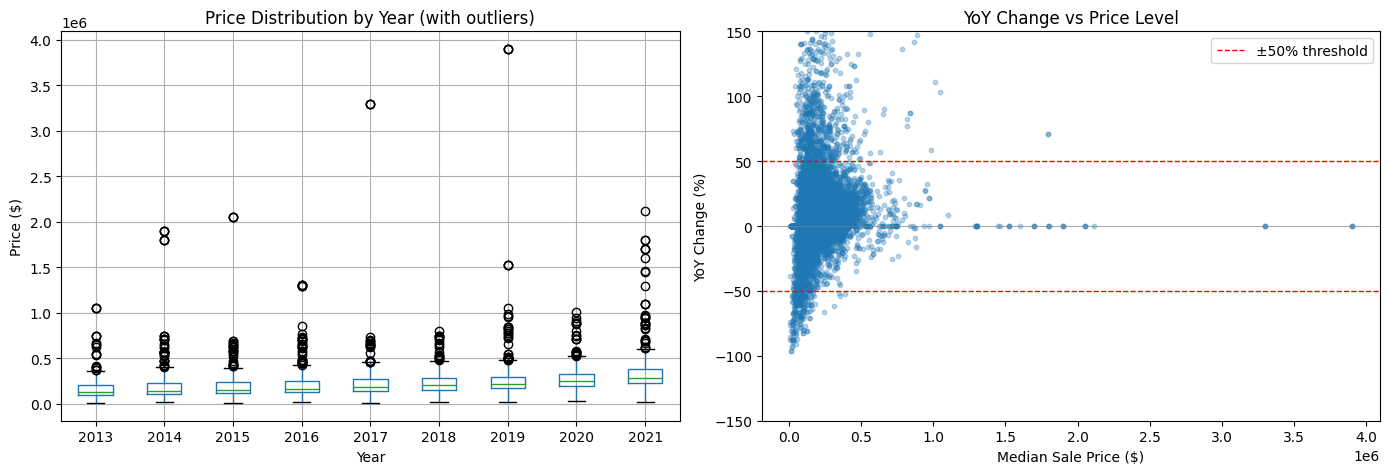


Example high-price outliers:
      region period_begin  median_sale_price  homes_sold state_code
5654   28280   2019-08-01          3900000.0           1         NC
1123   28280   2019-09-01          3900000.0           1         NC
7597   28280   2019-10-01          3900000.0           1         NC
9960   28280   2017-09-01          3300000.0           1         NC
5755   28280   2017-10-01          3300000.0           1         NC


In [37]:
# Price outliers using IQR method
q1 = df['median_sale_price'].quantile(0.25)
q3 = df['median_sale_price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['median_sale_price'] < lower_bound) | 
              (df['median_sale_price'] > upper_bound)]

print(f"Price outliers (IQR method): {len(outliers)} records ({len(outliers)/len(df)*100:.1f}%)")
print(f"  Lower bound: ${lower_bound:,.0f}")
print(f"  Upper bound: ${upper_bound:,.0f}")

# Extreme YoY changes
extreme_yoy = df[df['median_sale_price_yoy'].abs() > 0.5]
print(f"\nExtreme YoY changes (>50%): {len(extreme_yoy)} records ({len(extreme_yoy)/len(df)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of prices by year
df.boxplot(column='median_sale_price', by='year', ax=axes[0])
axes[0].set_title('Price Distribution by Year (with outliers)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Price ($)')
plt.suptitle('')

# Scatter of extreme changes
axes[1].scatter(df['median_sale_price'], df['median_sale_price_yoy']*100, alpha=0.3, s=10)
axes[1].axhline(y=50, color='red', linestyle='--', label='±50% threshold', linewidth=1)
axes[1].axhline(y=-50, color='red', linestyle='--', linewidth=1)
axes[1].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[1].set_title('YoY Change vs Price Level')
axes[1].set_xlabel('Median Sale Price ($)')
axes[1].set_ylabel('YoY Change (%)')
axes[1].legend()
axes[1].set_ylim(-150, 150)

plt.tight_layout()
plt.show()

# Show some outlier examples
if len(outliers) > 0:
    print("\nExample high-price outliers:")
    high_outliers = outliers.nlargest(5, 'median_sale_price')[['region', 'period_begin', 'median_sale_price', 'homes_sold', 'state_code']]
    print(high_outliers)

### COVID-19 Impact Analysis


📊 COVID-19 IMPACT ANALYSIS:
                         Pre-COVID (2019)  COVID Era (2020-2021)  % Change
Median Price ($)            215000.000000          265000.000000      23.3
Total Homes Sold            143300.000000          285224.000000      99.0
Median DOM (days)               57.500000              43.500000     -24.3
% Sold Above List               22.285008              37.542918      68.5
% Off Market in 2 Weeks         20.752787              29.255217      41.0


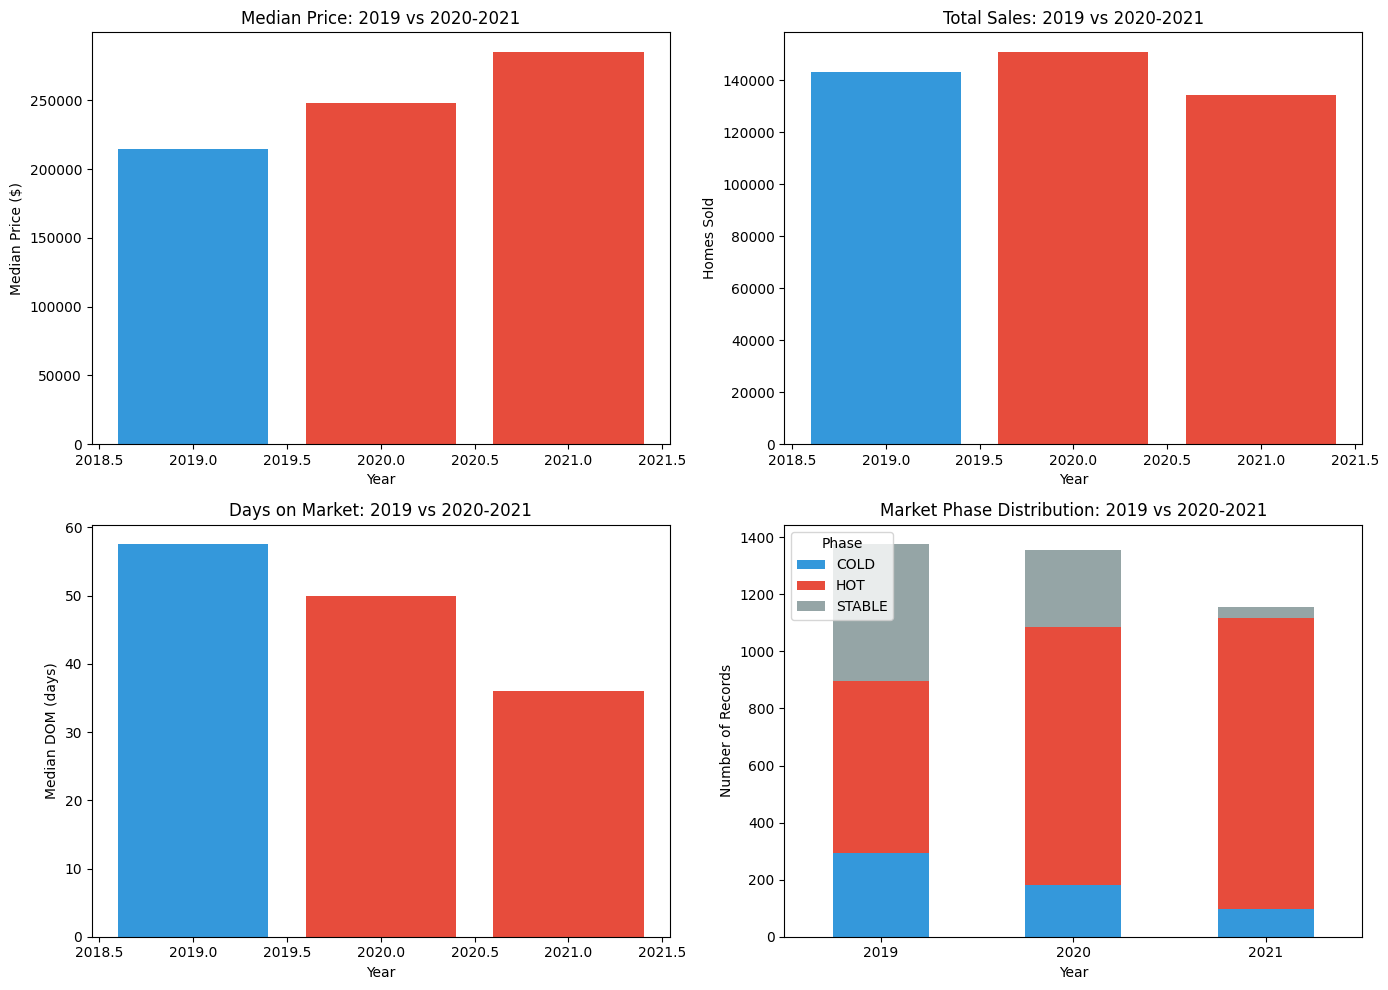

In [38]:
# Compare pre-COVID (2019) vs COVID era (2020-2021)
pre_covid = df[df['year'] == 2019]
covid = df[df['year'].isin([2020, 2021])]

comparison = pd.DataFrame({
    'Pre-COVID (2019)': [
        pre_covid['median_sale_price'].median(),
        pre_covid['homes_sold'].sum(),
        pre_covid['median_dom'].median(),
        pre_covid['sold_above_list'].mean() * 100,
        pre_covid['off_market_in_two_weeks'].mean() * 100
    ],
    'COVID Era (2020-2021)': [
        covid['median_sale_price'].median(),
        covid['homes_sold'].sum(),
        covid['median_dom'].median(),
        covid['sold_above_list'].mean() * 100,
        covid['off_market_in_two_weeks'].mean() * 100
    ]
}, index=['Median Price ($)', 'Total Homes Sold', 'Median DOM (days)', 
          '% Sold Above List', '% Off Market in 2 Weeks'])

comparison['% Change'] = ((comparison['COVID Era (2020-2021)'] - comparison['Pre-COVID (2019)']) / 
                           comparison['Pre-COVID (2019)'] * 100).round(1)

print("\n📊 COVID-19 IMPACT ANALYSIS:")
print(comparison)

# Visualize COVID impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price comparison
years_compare = df[df['year'].isin([2019, 2020, 2021])].groupby('year')['median_sale_price'].median()
axes[0,0].bar(years_compare.index, years_compare.values, color=['#3498db', '#e74c3c', '#e74c3c'])
axes[0,0].set_title('Median Price: 2019 vs 2020-2021')
axes[0,0].set_ylabel('Median Price ($)')
axes[0,0].set_xlabel('Year')

# Volume comparison
volume_compare = df[df['year'].isin([2019, 2020, 2021])].groupby('year')['homes_sold'].sum()
axes[0,1].bar(volume_compare.index, volume_compare.values, color=['#3498db', '#e74c3c', '#e74c3c'])
axes[0,1].set_title('Total Sales: 2019 vs 2020-2021')
axes[0,1].set_ylabel('Homes Sold')
axes[0,1].set_xlabel('Year')

# DOM comparison
dom_compare = df[df['year'].isin([2019, 2020, 2021])].groupby('year')['median_dom'].median()
axes[1,0].bar(dom_compare.index, dom_compare.values, color=['#3498db', '#e74c3c', '#e74c3c'])
axes[1,0].set_title('Days on Market: 2019 vs 2020-2021')
axes[1,0].set_ylabel('Median DOM (days)')
axes[1,0].set_xlabel('Year')

# Market phase distribution
phase_compare = df[df['year'].isin([2019, 2020, 2021])].groupby(['year', 'market_phase']).size().unstack(fill_value=0)
phase_compare.plot(kind='bar', stacked=True, ax=axes[1,1], 
                   color=[colors_pie.get(c, 'gray') for c in phase_compare.columns])
axes[1,1].set_title('Market Phase Distribution: 2019 vs 2020-2021')
axes[1,1].set_ylabel('Number of Records')
axes[1,1].set_xlabel('Year')
axes[1,1].legend(title='Phase')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Save Cleaned Data

In [39]:
# Save the cleaned data to CSV for preprocessing
df.to_csv('charlotte_cleaned_data.csv', index=False)
print("Saved charlotte_cleaned_data.csv")

Saved charlotte_cleaned_data.csv


## Pre-Processing

In [40]:
# Load cleaned data for preprocessing
df = pd.read_csv('charlotte_cleaned_data.csv')

In [41]:
# ============================================
# STEP 1: HANDLE TARGET VARIABLE
# ============================================
# Log-transform target (addresses right skew)
df['log_price'] = np.log(df['median_sale_price'])

# ============================================
# STEP 2: REMOVE LEAKAGE FEATURES
# ============================================
leakage_features = ['median_list_price', 'median_ppsf']
df = df.drop(columns=leakage_features)

# ============================================
# STEP 3: REMOVE MULTICOLLINEAR FEATURES
# ============================================
multicollinear_drop = ['new_listings', 'new_listings_mom', 'new_listings_yoy']
df = df.drop(columns=multicollinear_drop)

# ============================================
# STEP 4: ADD COVID ERA FEATURE
# ============================================
df['covid_era'] = (df['year'] >= 2020).astype(int)

# ============================================
# STEP 5: ENCODE CATEGORICAL FEATURES
# ============================================
# State code
df['state_NC'] = (df['state_code'] == 'NC').astype(int)

# Quarter (one-hot)
df = pd.get_dummies(df, columns=['quarter'], prefix='Q')

# Market phase for classification (label encode)
phase_map = {'COLD': 0, 'STABLE': 1, 'HOT': 2}
df['market_phase_encoded'] = df['market_phase'].map(phase_map)

# ============================================
# STEP 6: CAP OUTLIERS (optional)
# ============================================
price_cap = df['median_sale_price'].quantile(0.99)
df['median_sale_price_capped'] = df['median_sale_price'].clip(upper=price_cap)

# ============================================
# STEP 7: DEFINE FEATURE SETS
# ============================================
# For Regression (predicting price)
regression_features = [
    'homes_sold', 'inventory', 'median_dom', 
    'off_market_in_two_weeks', 'avg_sale_to_list', 'sold_above_list',
    'median_sale_price_mom', 'median_sale_price_yoy',
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy',
    'year', 'state_NC', 'covid_era',
    'Q_1', 'Q_2', 'Q_3', 'Q_4'
]

# For Classification (predicting market phase)
classification_features = [
    'homes_sold', 'inventory', 'median_dom',
    'off_market_in_two_weeks', 'avg_sale_to_list', 'sold_above_list',
    'median_sale_price_mom', 'median_sale_price_yoy',
    'homes_sold_yoy', 'inventory_yoy', 'median_dom_yoy',
    'year', 'state_NC',
    'Q_1', 'Q_2', 'Q_3', 'Q_4'
]

print(f"Regression features: {len(regression_features)}")
print(f"Classification features: {len(classification_features)}")

# Save preprocessed data
df.to_csv('charlotte_preprocessed.csv', index=False)

Regression features: 21
Classification features: 17


In [43]:
# Filter to zips with 30+ quarters for LSTM
time_coverage = df.groupby('region').size().reset_index(name='quarters')
complete_zips = time_coverage[time_coverage['quarters'] >= 30]['region'].tolist()

df_timeseries = df[df['region'].isin(complete_zips)]
df_timeseries.to_csv('charlotte_timeseries.csv', index=False)

print(f"Time series dataset: {len(df_timeseries)} records, {len(complete_zips)} zip codes")

Time series dataset: 11533 records, 113 zip codes
